<h1>Определение перспективных и невыгодных источников трафика<span 
class="tocSkip"></span></h1>

**Описание проекта**

Вас пригласили на стажировку в отдел маркетинговой аналитики Яндекс.Афиши. Первое задание: помочь маркетологам снизить расходы — отказаться от невыгодных источников трафика и перераспределить бюджет.

Есть данные Яндекс.Афиши с июня 2017 по конец мая 2018 года:
- лог сервера с данными о посещениях сайта Яндекс.Афиши,
- выгрузка всех заказов за этот период,
- статистика рекламных расходов.

Предстоит изучить:
- как клиенты пользуются сервисом,
- когда делают первые покупки на сайте,
- сколько денег приносит компании каждый клиент,
- когда расходы на привлечение клиента окупаются.
Выручка измеряется в условных единицах — у.е.


Цели проекта:
- помочь маркетологам снизить расходы — отказаться от невыгодных источников трафика и перераспределить бюджет;
- определить источники трафика, на которые маркетологам стоит делать упор;
- определить самые перспективные для компании когорты клиентов;

# План проекта: #

1. [Загрузка данных и подготовка их к анализу](#cell1)
2. [Рассчёт метрик и построение графиков](#cell2)
   - 2.1 [Продуктовые метрики](#cell3)
   - 2.2 [Метрики электронной коммерции](#cell4)
   - 2.3 [Маркетинговые метрики](#cell5)
5. [Выводы и рекомендации](#cell6)

## Загрузка данных и подготовка их к анализу
<a id='cell1'></a>

Импортируем различные библиотеки:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import stats as st
import copy
import requests
import re
from bs4 import BeautifulSoup
import json
import random 
import seaborn as sns
import plotly.graph_objects as go

Прочитаем приложенные файлы и сохраним их в переменные:

In [2]:
data_visits = pd.read_csv('/datasets/visits_log.csv')
data_orders = pd.read_csv('/datasets/orders_log.csv')
data_costs = pd.read_csv('/datasets/costs.csv')

Общая информация о таблицах и первые строки таблиц:

In [3]:
data_visits.info()
data_visits.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


In [4]:
data_orders.info()
data_orders.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [5]:
data_costs.info()
data_costs.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


**Описание данных**

В нашем распоряжении три датасета.

- visits_log.csv - хранит лог сервера с информацией о посещениях сайта, 
- orders_log.csv — информацию о заказах, 
- costs.csv — информацию о расходах на маркетинг.

Структура visits_log.csv
- Uid — уникальный идентификатор пользователя,
- Device — категория устройства пользователя,
- Start Ts — дата и время начала сессии,
- End Ts — дата и время окончания сессии,
- Source Id — идентификатор источника перехода на сайт.

Структура orders_log.csv
- Uid — уникальный идентификатор пользователя,
- Buy Ts — дата и время заказа,
- Revenue — сумма заказа.

Структура costs.csv
- source_id — идентификатор рекламного источника,
- dt — дата проведения рекламной кампании,
- costs — расходы на эту кампанию.

Проверим данные на наличие пропусков:

In [6]:
data_visits.isnull().sum()

Device       0
End Ts       0
Source Id    0
Start Ts     0
Uid          0
dtype: int64

In [7]:
data_orders.isnull().sum()

Buy Ts     0
Revenue    0
Uid        0
dtype: int64

In [8]:
data_costs.isnull().sum()

source_id    0
dt           0
costs        0
dtype: int64

В предоставленных данных пропуски отсутвуют.

Изменим название столбцов в таблицах(приведём к нижнему регистру):

In [9]:
data_visits.columns = data_visits.columns.str.lower()
data_orders.columns = data_orders.columns.str.lower()
data_costs.columns = data_costs.columns.str.lower()

Изменим название столбцов в таблицах:

In [10]:
data_visits.columns = ['device', 'end_ts', 'source_id', 'start_ts', 'uid']
data_orders.columns = ['buy_ts', 'revenue', 'uid']

Преобразуем данные в нужные типы:

In [11]:
data_visits['end_ts'] = pd.to_datetime(data_visits['end_ts'])
data_visits['start_ts'] = pd.to_datetime(data_visits['start_ts'])
data_orders['buy_ts'] = pd.to_datetime(data_orders['buy_ts'])
data_costs['dt'] = pd.to_datetime(data_costs['dt'])

Добавим необходимые столбцы к таблицам:

In [12]:
data_visits['data_visits_year']  = data_visits['start_ts'].dt.year
data_visits['data_visits_month'] = data_visits['start_ts'].dt.month
data_visits['data_visits_week']  = data_visits['start_ts'].dt.week
data_visits['data_visits_date'] = data_visits['start_ts'].dt.date
data_orders['data_orders_year']  = data_orders['buy_ts'].dt.year
data_orders['data_orders_month']  = data_orders['buy_ts'].dt.month
data_orders['data_orders_week']  = data_orders['buy_ts'].dt.week
data_orders['data_orders_date']  = data_orders['buy_ts'].dt.date
data_costs['data_costs_year']  = data_costs['dt'].dt.year
data_costs['data_costs_month'] = data_costs['dt'].dt.month
data_costs['data_costs_week']  = data_costs['dt'].dt.week
data_costs['data_costs_date'] = data_costs['dt'].dt.date

Найдём и добавим время первой сессии и время первого заказа:

In [13]:
data_first_session = data_visits.groupby(['uid']).agg({'start_ts':'min', 'source_id':'first'})
data_first_session.columns = ['first_activity', 'first_source']

data_first_order = data_orders.groupby(['uid']).agg({'buy_ts':'min'})
data_first_order.columns = ['first_buy_ts']

first_order = data_first_order.join(data_first_session, on = 'uid')

Проверим данные на наличие дубликатов:

In [14]:
print(data_visits.duplicated().sum())
print(data_orders.duplicated().sum())
print(data_costs.duplicated().sum())

0
0
0


В предоставленных данных дубликаты отсутствуют.

Проверим данные на соответсвие заданному в условии временному интервалу:

In [15]:
data_visits['start_ts'].describe()

count                  359400
unique                 224303
top       2017-11-24 16:06:00
freq                       19
first     2017-06-01 00:01:00
last      2018-05-31 23:59:00
Name: start_ts, dtype: object

In [16]:
data_orders['buy_ts'].describe()

count                   50415
unique                  45991
top       2018-05-31 10:13:00
freq                        9
first     2017-06-01 00:10:00
last      2018-06-01 00:02:00
Name: buy_ts, dtype: object

In [17]:
data_costs['dt'].describe()

count                    2542
unique                    364
top       2018-03-03 00:00:00
freq                        7
first     2017-06-01 00:00:00
last      2018-05-31 00:00:00
Name: dt, dtype: object

Предоставленные данные соответсвуют заданному в условии временному интервалу.

**Вывод**

С предоставленными данными ознакомились. В данных отсутствуют пропуски, были изменены названия столбцов(и привели их к нижнему регистру), изменены типы данных в столбцах и добавлены дополнительные столбцы.

## Рассчёт метрик и построение графиков
<a id='cell2'></a>

### Продуктовые метрики
<a id='cell3'></a>

**2.1.1.** Рассчитаем DAU, WAU и MAU. Вычислим средние значения этих метрик за весь период. Отобразим изменения метрик во времени на графиках:

Средние количество уникальных пользователей в день: 907
Средние количество пользователей в день: 987


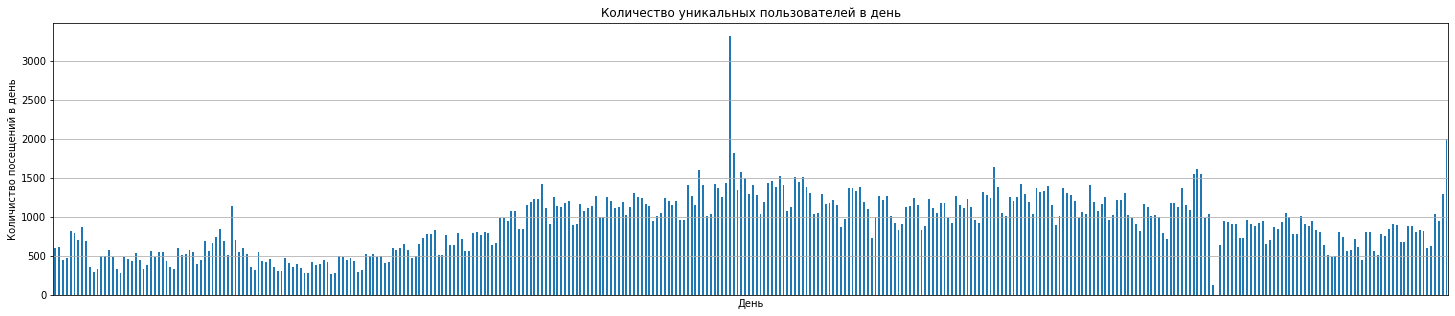

In [18]:
dau_total = data_visits.groupby('data_visits_date').agg({'uid': 'nunique'}).mean()
dau_total_all = data_visits.groupby('data_visits_date').agg({'uid': 'count'}).mean()
print('Средние количество уникальных пользователей в день:', int(dau_total))
print('Средние количество пользователей в день:', int(dau_total_all))
dau_total = data_visits.groupby('data_visits_date').agg({'uid': 'nunique'})
dau_total.plot(grid=True, kind='bar', figsize=(25, 5), legend=False)
plt.title('Количество уникальных пользователей в день')
plt.ylabel('Количиство посещений в день')
plt.xlabel('День')
plt.xticks([])
plt.show()


Средние количество уникальных пользователей в день: 907. Видна заметная разница в количестве между первыми тремя месяцами(лето) и последующими шестью месяцами(осень и зима).

Средние количество уникальных пользователей в неделю: 5716
Средние количество пользователей в неделю: 6781


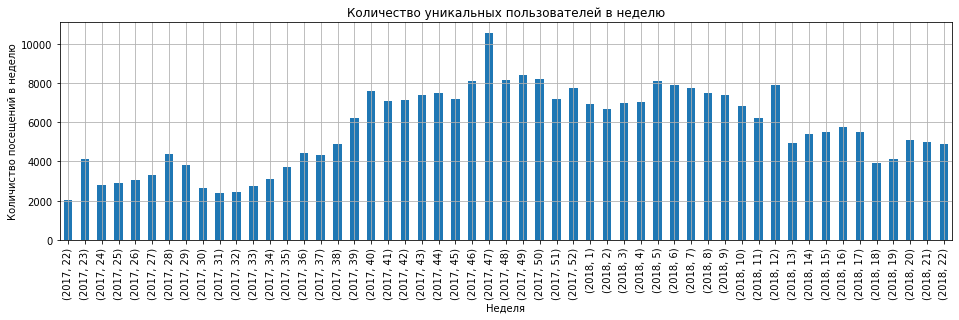

In [19]:
wau_total = (data_visits.groupby(['data_visits_year', 'data_visits_week']).agg({'uid': 'nunique'}).mean())
wau_total_all = (data_visits.groupby(['data_visits_year', 'data_visits_week']).agg({'uid': 'count'}).mean())
print('Средние количество уникальных пользователей в неделю:', int(wau_total))
print('Средние количество пользователей в неделю:', int(wau_total_all))
wau_total = (data_visits.groupby(['data_visits_year', 'data_visits_week']).agg({'uid': 'nunique'}))
wau_total.plot(grid=True, kind='bar', figsize=(16, 4), legend=False)
plt.title('Количество уникальных пользователей в неделю')
plt.xlabel('Неделя')
plt.ylabel('Количиство посещений в неделю')
plt.show()

Начиная с 39 недели 2017 года и по 12 неделю 2018 года количество уникальных пользователей более 6 тысяч в неделю. В другое время виден заметный спад, особенно с 22 по 35 недели.

Средние количество уникальных пользователей в месяц: 23228
Средние количество пользователей в месяц: 29950


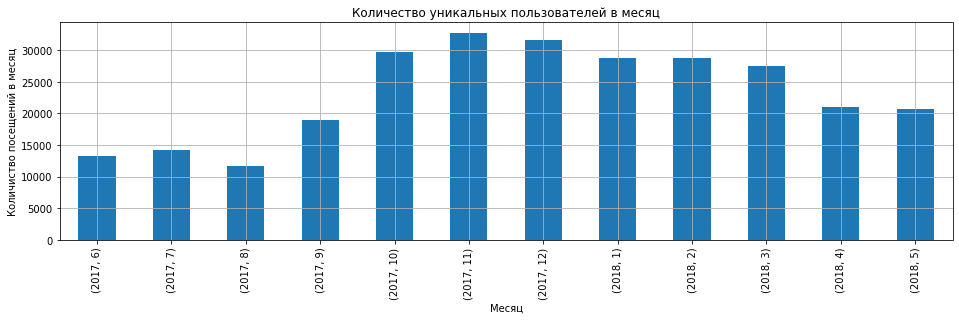

In [20]:
mau_total = (data_visits.groupby(['data_visits_year', 'data_visits_month']).agg({'uid': 'nunique'}).mean())
mau_total_all = (data_visits.groupby(['data_visits_year', 'data_visits_month']).agg({'uid': 'count'}).mean())
print('Средние количество уникальных пользователей в месяц:', int(mau_total))
print('Средние количество пользователей в месяц:', int(mau_total_all))
mau_total = (data_visits.groupby(['data_visits_year', 'data_visits_month']).agg({'uid': 'nunique'}))
mau_total.plot(grid=True, kind='bar', figsize=(16, 4), legend=False)
plt.title('Количество уникальных пользователей в месяц')
plt.xlabel('Месяц')
plt.ylabel('Количиство посещений в месяц')
plt.show()

Пиковые значения с ноября по март. Наименьшее количество новых пользователей с июня по август.

Количество уникальных пользователей в летнее время значительно меньше(возможно это связано с сезоном отпусков), чем в осеннее и зимнее время(возможно это связано с погодными условиями, в осеннее и зимнее время пользователи чаще сидят дома и проводят время в сети интернет, а возможно и с большим количеством зимних праздников). Крайне редко клиенты посещают сайт более 1 раза в месяц.

**2.1.2.** Определим, сколько раз за день пользователи в среднем заходят на сайт. Построим график, отражающий изменения метрики во времени:

В среднем, пользователи заходят на сайт 987 раз в день


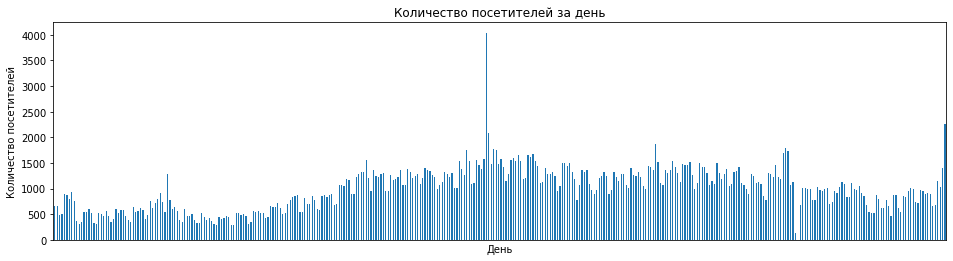

In [21]:
day_count = data_visits.groupby(['data_visits_year', 'data_visits_date']).agg({'uid': 'count'}).mean()
print('В среднем, пользователи заходят на сайт', int(day_count), 'раз в день')
day_count = data_visits.groupby(['data_visits_year', 'data_visits_date']).agg({'uid': 'count'})
day_count.plot(grid=False, kind='bar', figsize=(16, 4), legend=False)
plt.title('Количество посетителей за день')
plt.xlabel('День')
plt.ylabel('Количество посетителей')
plt.xticks([])
plt.show()

В среднем, пользователи заходят на сайт 987 раз в день.

In [22]:
print('Cреднее число сессий в день на одного пользователя в день:', round(float(data_visits.groupby(['data_visits_year', 'data_visits_date', 'uid']).agg({'uid': 'count'}).mean()), 2))
print('Cреднее число сессий в день на одного пользователя в неделю:', round(float(data_visits.groupby(['data_visits_year', 'data_visits_week', 'uid']).agg({'uid': 'count'}).mean()), 2))
print('Cреднее число сессий в день на одного пользователя в месяц:', round(float(data_visits.groupby(['data_visits_year', 'data_visits_month', 'uid']).agg({'uid': 'count'}).mean()), 2))
print('Cреднее число сессий в день на одного пользователя в год:', round(float(data_visits.groupby(['data_visits_year', 'uid']).agg({'uid': 'count'}).mean()), 2))

Cреднее число сессий в день на одного пользователя в день: 1.09
Cреднее число сессий в день на одного пользователя в неделю: 1.19
Cреднее число сессий в день на одного пользователя в месяц: 1.29
Cреднее число сессий в день на одного пользователя в год: 1.47


Клиенты пользуются сервисом редко. Повторные обращения к сервису есть, но их не очень много. В среднем пользователи совершают 1 сессию в день. За год повторно возвращаются около половины клиентов.

**2.1.3.** Исследуем, сколько времени пользователи проводят на сайте. Узнаем продолжительность типичной пользовательской сессии за весь период. Построем график распределения:

0    60
dtype: int64


count    359400.000000
mean        643.506489
std        1016.334786
min           0.000000
25%         120.000000
50%         300.000000
75%         840.000000
max       84480.000000
Name: session_duration_sec, dtype: float64

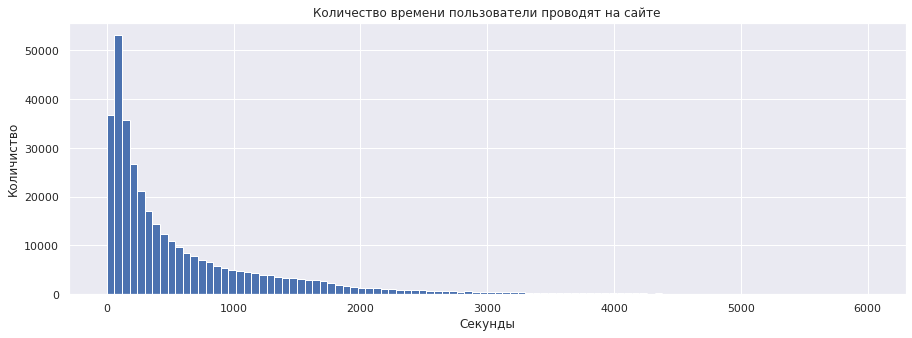

In [23]:
data_visits['session_duration_sec'] = (data_visits['end_ts'] - data_visits['start_ts']).dt.seconds
print(data_visits['session_duration_sec'].mode())
sns.set()
data_visits['session_duration_sec'].hist(bins= 100, range = [0,6000],figsize = (15,5))
plt.title('Количество времени пользователи проводят на сайте')
plt.xlabel('Секунды')
plt.ylabel('Количиство')
data_visits['session_duration_sec'].describe()

Когда распределение близко к нормальному или нормальное — можно смотреть на среднюю или медиану. Наше — не из таких, рассчитаем моду (значение в выборке, которое встречается чаще всего): Чаще всего встречатеся значение - 60 секунд. Продолжительность типичной пользовательской сессии - 60 секунд.

Продолжительность средней пользовательской сессии: 10 минут
Медиана продолжительности пользовательской сессии: 5 минут
Продолжительность средней пользовательской сессии: 0    60
dtype: int64
count    359400.000000
mean         10.725108
std          16.938913
min           0.000000
25%           2.000000
50%           5.000000
75%          14.000000
max        1408.000000
Name: session_duration_minuts, dtype: float64


(1, 50)

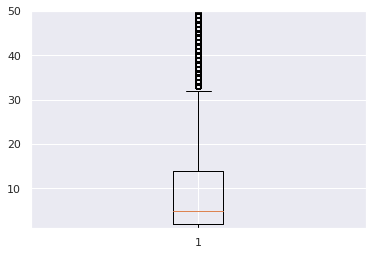

In [24]:
data_visits['session_duration_seconds'] = (data_visits['end_ts'] - data_visits['start_ts']).dt.seconds
data_visits['session_duration_minuts'] = data_visits['session_duration_seconds'] / 60
print('Продолжительность средней пользовательской сессии:', int(data_visits['session_duration_minuts'].mean()), 'минут')
print('Медиана продолжительности пользовательской сессии:', int(data_visits['session_duration_minuts'].median()), 'минут')
print('Продолжительность средней пользовательской сессии:', data_visits['session_duration_sec'].mode())
data_visits_boxplot = data_visits['session_duration_minuts']
print(data_visits_boxplot.describe())
plt.boxplot(data_visits_boxplot)
plt.ylim(1,50)

Медиана продолжительности пользовательской сессии: 5 минут. Продолжительность 75% пользовательских сессии состовляет до 15 минут.

**2.1.4.** Рассчитайте Retention Rate, применяя когортный анализ. Покажите изменения метрики во времени на графике. Найдите средний Retention Rate на второй месяц «жизни» когорт:

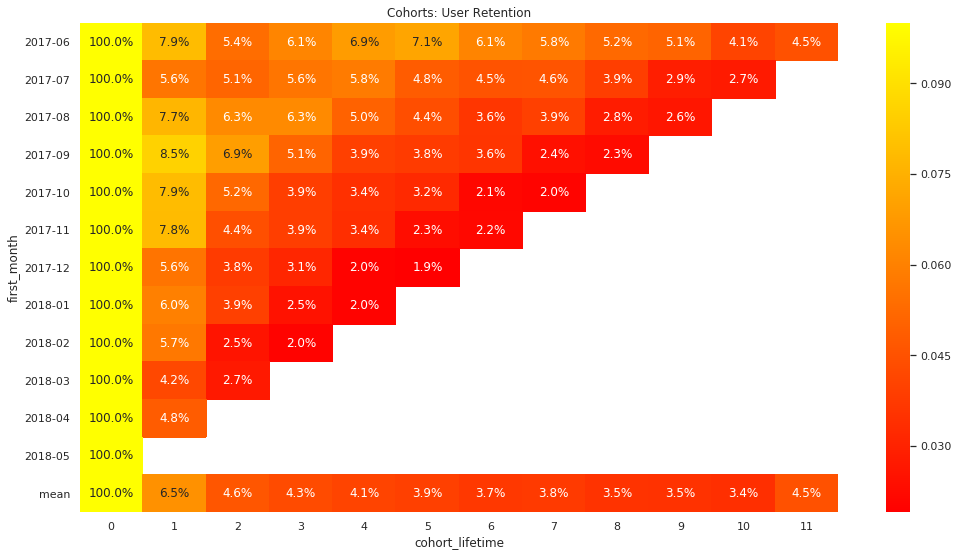

In [25]:
data_visits_copy = data_visits
first_session = data_visits_copy.groupby('uid')['start_ts'].min()
first_session.name = 'first_session'
visits = pd.merge(data_visits_copy, first_session, on='uid')
visits['first_month'] = visits['first_session'].astype('datetime64[M]')
visits['session_month'] = visits['start_ts'].astype('datetime64[M]')
visits['cohort_lifetime'] = ((visits['session_month'] - visits['first_month']) / np.timedelta64(1,'M')).round().astype('int')
visits['first_month'] = visits['first_month'].dt.strftime('%Y-%m')

cohorts = visits.groupby(['first_month','cohort_lifetime'])['uid'].nunique().reset_index()

inital_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_month','uid']]
inital_users_count = inital_users_count.rename(columns={'uid':'cohort_users'})

cohorts = cohorts.merge(inital_users_count,on='first_month')
cohorts['retention'] = cohorts['uid'] / cohorts['cohort_users']

retention_pivot = cohorts.pivot_table(
    index='first_month',
    columns='cohort_lifetime',
    values='retention',aggfunc='sum')
retention_pivot.fillna('')

retention_pivot.loc['mean'] = retention_pivot.mean()

sns.set(style='white')
plt.figure(figsize=(17, 9))
plt.title('Cohorts: User Retention')
sns.heatmap(retention_pivot, annot=True, fmt='.1%',vmax=0.10,cmap="autumn");

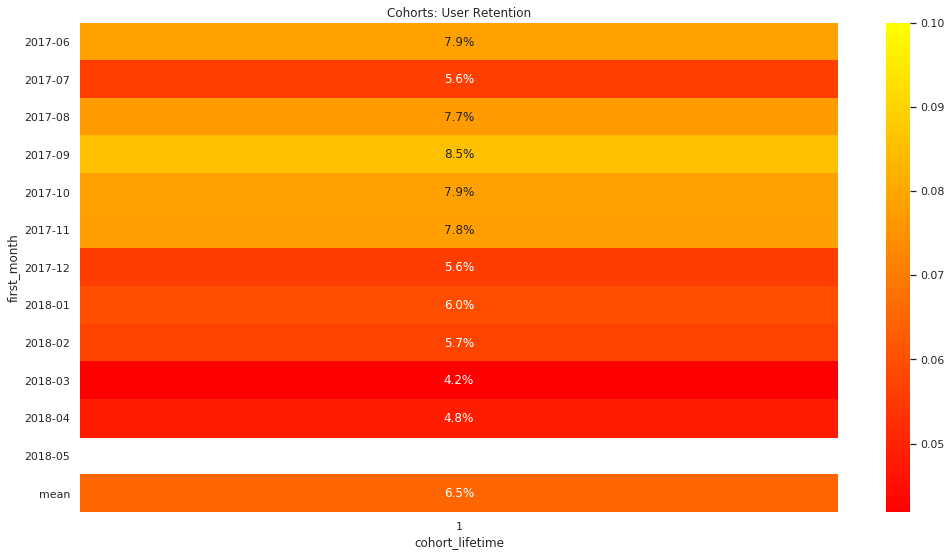

In [26]:
retention_pivot = cohorts.pivot_table(
    index='first_month',
    columns='cohort_lifetime',
    values='retention',aggfunc='sum')
retention_pivot.fillna('')

retention_pivot.loc['mean'] = retention_pivot.mean()

retention_pivot = retention_pivot[[1]]
sns.set(style='white')
plt.figure(figsize=(17, 9))
plt.title('Cohorts: User Retention')
sns.heatmap(retention_pivot, annot=True, fmt='.1%',vmax=0.10,cmap="autumn");

Во втором месяце возвращается менее 10% клиентов, в среднем это 6,5%. C каждой новой кагортой, ситуация только ухудшается.

### Метрики электронной коммерции
<a id='cell4'></a>

**2.2.1.** Исследуем, сколько времени в среднем проходит с момента первого посещения сайта до совершения покупки:

In [27]:
first_visits = data_visits.groupby('uid').agg({'start_ts': 'min'}).reset_index()
first_visits.columns = ['uid', 'first_visit']
print(first_visits.head()) 

               uid         first_visit
0   11863502262781 2018-03-01 17:27:00
1   49537067089222 2018-02-06 15:55:00
2  297729379853735 2017-06-07 18:47:00
3  313578113262317 2017-09-18 22:49:00
4  325320750514679 2017-09-30 14:29:00


In [28]:
first_orders = data_orders.groupby('uid').agg({'buy_ts': 'min'}).reset_index()
first_orders.columns = ['uid', 'first_order']
print(first_orders.head()) 

                uid         first_order
0   313578113262317 2018-01-03 21:51:00
1  1575281904278712 2017-06-03 10:13:00
2  2429014661409475 2017-10-11 18:33:00
3  2464366381792757 2018-01-28 15:54:00
4  2551852515556206 2017-11-24 10:14:00


Среднее время с момента первого посещения сайта до совершения покупки 249 минут
Медианное время с момента первого посещения сайта до совершения покупки 16 минут
Мода с момента первого посещения сайта до совершения покупки 0    1.0
dtype: float64 минут


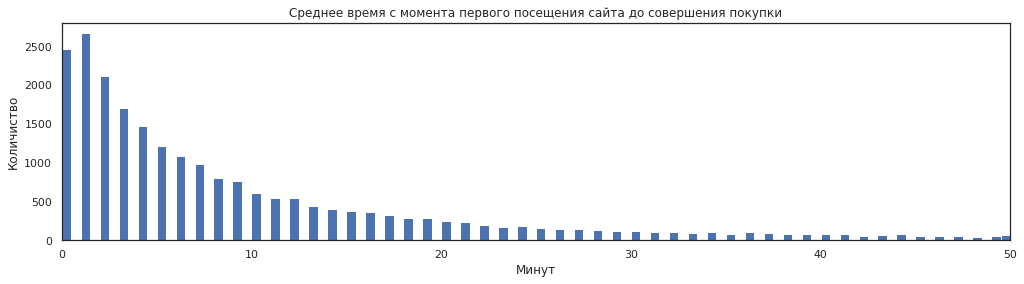

count    36523.000000
mean       249.164691
std        429.742785
min          0.000000
25%          4.000000
50%         16.000000
75%        252.000000
max       1439.000000
Name: time, dtype: float64

In [29]:
visits_orders = pd.merge(first_visits, first_orders, on='uid')
visits_orders['time'] = (visits_orders['first_order'] - visits_orders['first_visit']).dt.seconds
visits_orders['time'] = visits_orders['time'] / 60
print('Среднее время с момента первого посещения сайта до совершения покупки', int(visits_orders['time'].mean()), 'минут')
print('Медианное время с момента первого посещения сайта до совершения покупки', int(visits_orders['time'].median()), 'минут')
print('Мода с момента первого посещения сайта до совершения покупки', visits_orders['time'].mode(), 'минут')
visits_orders['time'].plot(kind = 'hist', bins = 100, range = (0,50), figsize = (17,4))
plt.title('Среднее время с момента первого посещения сайта до совершения покупки')
plt.xlim(0,50)
plt.xlabel('Минут')
plt.ylabel('Количиство')
plt.show()
visits_orders['time'].describe()


Когда распределение близко к нормальному или нормальное — можно смотреть на среднюю или медиану. Наше — не из таких, рассчитаем моду (значение в выборке, которое встречается чаще всего): больше всего первых заказов совершается в промежутке между 1 и 2 минутой от начала первой сессии. Для совершения первой покупки, 50% клиентам требуется не более 16 минут.

**2.2.2.** Рассчитаем среднее количество покупок на одного покупателя за 7 месяцев 2017 года:

In [30]:
data_orders1 = data_orders.query('data_orders_year == 2017')
print('Cреднее количество покупок на одного покупателя за 7 месяцев 2017 года:', round(float(data_orders1.groupby(['uid']).agg({'uid': 'count'}).mean()), 2))
print('Медианное количество покупок на одного покупателя за 7 месяцев 2017 года:', round(float(data_orders1.groupby(['uid']).agg({'uid': 'count'}).median()), 2))

Cреднее количество покупок на одного покупателя за 7 месяцев 2017 года: 1.33
Медианное количество покупок на одного покупателя за 7 месяцев 2017 года: 1.0


Повторные покупки есть, но они редки. Менее половины клиентов совершили повторные покупки за 7 месяцев 2017 года, необходимо принимать меры для улучшения данного показателя.

**2.2.3.** Рассчитайте средний чек, применяя группировку по времени совершения покупки. Когортный анализ не подходит — он может исказить расчёты. Постройте график, отражающий изменения метрики во времени:

Средний чек: 5.0
                                     revenue
data_orders_year data_orders_month          
2017             6                  4.060106
                 7                  5.306589
                 8                  4.847139
                 9                  5.416448
                 10                 4.928280
                 11                 4.783518
                 12                 5.852139
2018             1                  4.112927
                 2                  4.840095
                 3                  5.413930
                 4                  5.150645
                 5                  4.771279
                 6                  3.420000


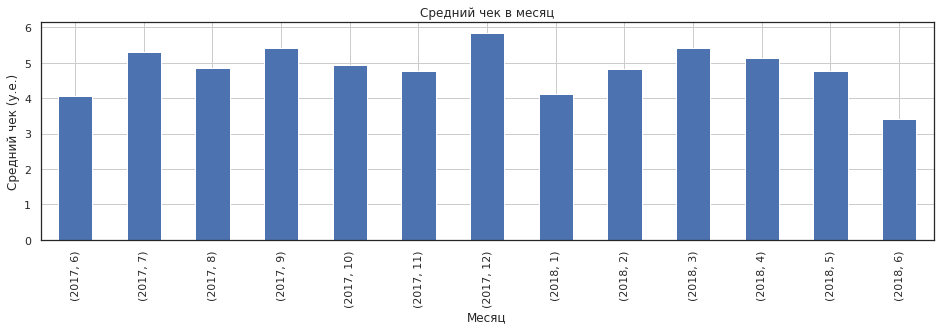

In [31]:
orders_avr = data_orders.groupby(['data_orders_year', 'data_orders_month']).agg({'revenue': 'mean'})
print('Средний чек:', round(data_orders['revenue'].mean(), 2))
print(orders_avr)
orders_avr.plot(grid=True, kind='bar', figsize=(16, 4), legend=False)
plt.title('Средний чек в месяц')
plt.xlabel('Месяц')
plt.ylabel('Средний чек (у.е.)')
plt.show()

(0, 13)

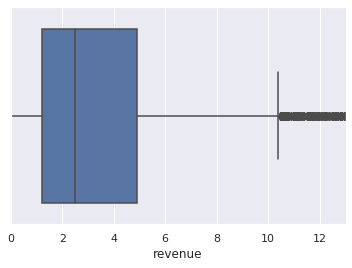

In [32]:
sns.set()
a = sns.boxplot(x=data_orders['revenue'])
a.set_xlim([0, 13])

Средний чек составляет 5 у.е. В 'холодное' время года возрастает количество покупателей. Максимальный средний чек приходится на декабрь, вероятно, это связано с новогодними праздниками.

**2.2.4.** Выясним, как меняется LTV на покупателя по когортам. Рассчитаем средний LTV по когортам за 6 месяцев. Маржинальность сервиса — 100%:

LTV (от англ. lifetime value) — «пожизненная» ценность клиента. Это — итоговая сумма денег, которую один клиент приносит в среднем со всех своих покупок. При расчёте LTV обычно обращаются к валовой прибыли с клиента за период.

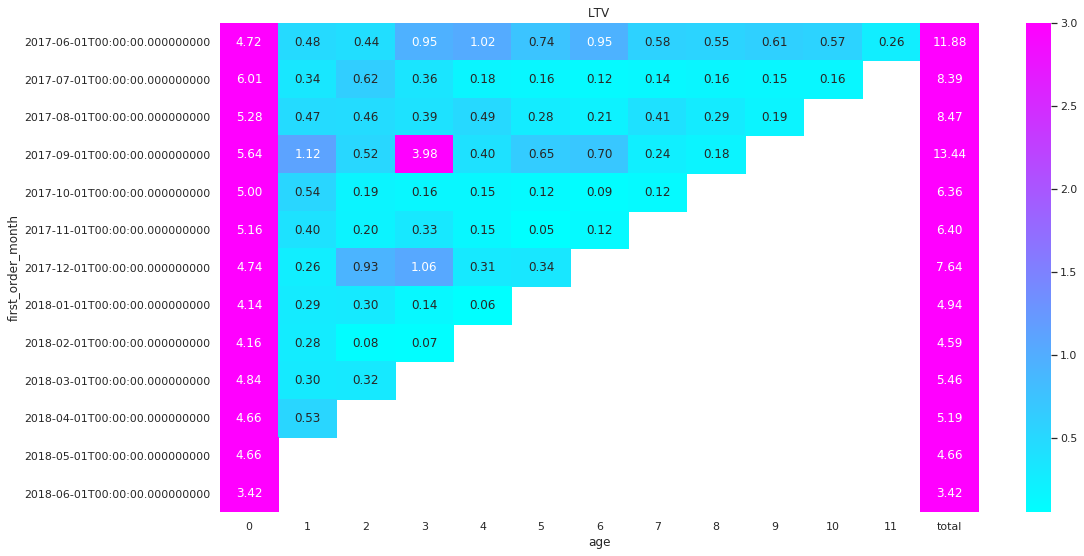

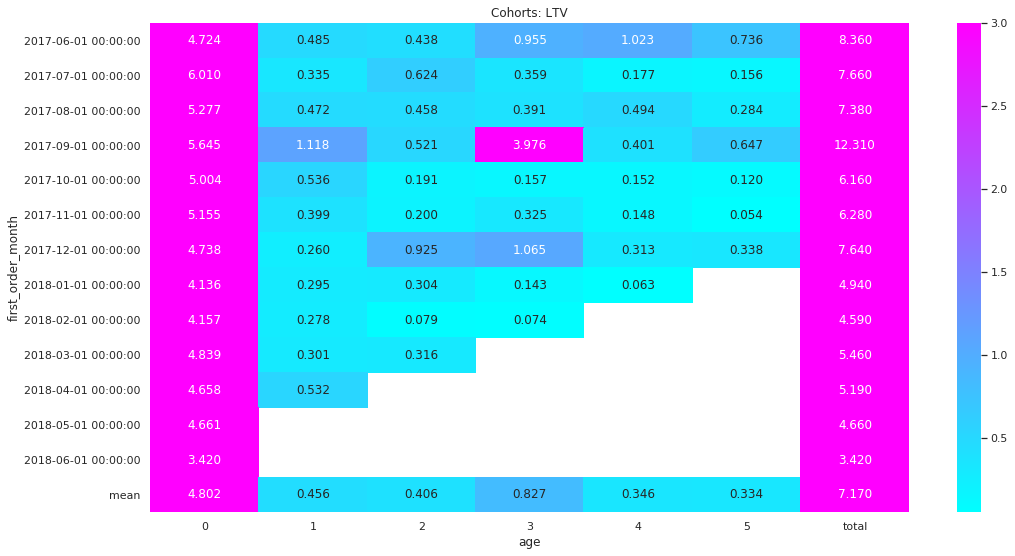

In [33]:
data_orders_copy = data_orders
data_costs_copy = data_costs
data_visits_copy = data_visits
data_orders_copy = data_orders_copy.drop(['data_orders_year', 'data_orders_month', 'data_orders_week', 'data_orders_date'], axis = 1)
data_costs_copy = data_costs_copy.drop(['data_costs_year', 'data_costs_month', 'data_costs_week', 'data_costs_date'], axis = 1)
# Выделим месяцы из дат в таблицах с заказами и расходами:
data_orders_copy['order_month'] = data_orders_copy['buy_ts'].astype('datetime64[M]')
data_costs_copy['month'] = data_costs_copy['dt'].astype('datetime64[M]')
# Получим месяц первой покупки каждого покупателя:
first_orders = data_orders_copy.groupby('uid').agg({'order_month': 'min'}).reset_index()
first_orders.columns = ['uid', 'first_order_month']
# Посчитаем количество новых покупателей (n_buyers) за каждый месяц:
cohort_sizes = (first_orders.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index())
cohort_sizes.columns = ['first_order_month', 'n_buyers']
# Добавим месяц первой покупки каждого покупателя в таблицу с заказами:
orders_new = pd.merge(data_orders_copy, first_orders, on='uid')
# Сгруппируем таблицу заказов по месяцу первой покупки и месяцу каждого заказа и сложим выручку:
cohorts = (orders_new.groupby(['first_order_month', 'order_month']).agg({'revenue': 'sum'}).reset_index())
# Добавим в таблицу cohorts данные о том, сколько людей первый раз совершили покупку в каждый месяц:
report = pd.merge(cohort_sizes, cohorts, on='first_order_month')

margin_rate = 1
report['first_order_month'] = report['first_order_month'].astype('datetime64[M]')
report['gp'] = report['revenue'] * margin_rate
report['age'] = (report['order_month'] - report['first_order_month']) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')

report['ltv'] = report['gp'] / report['n_buyers']

output = report.pivot_table(index='first_order_month', columns='age', values='ltv', aggfunc='mean').round(2)
output.fillna('')

output = report.pivot_table(
        index='first_order_month', 
        columns='age', 
        values='ltv', 
        aggfunc='mean').round(3)

sns.set(style='white')
plt.figure(figsize=(17, 9))
plt.title('LTV')
output['total'] = output.sum(axis=1).round(2)
sns.heatmap(output, annot=True, fmt='.2f',vmax=3,cmap="cool")

output = report.pivot_table(
        index='first_order_month', 
        columns='age', 
        values='ltv', 
        aggfunc='mean').round(3)

output.loc['mean'] = output.mean()

output = output[[0,1,2,3,4,5]]
sns.set(style='white')
plt.figure(figsize=(17, 9))
plt.title('Cohorts: LTV')
output['total'] = output.sum(axis=1).round(2)
sns.heatmap(output, annot=True, fmt='.3f',vmax=3,cmap="cool")


In [34]:
monthly_costs = data_costs_copy.groupby('month').sum()
report_new = pd.merge(report, monthly_costs, left_on='first_order_month', right_on='month')
report_new['cac'] = report_new['costs'] / report_new['n_buyers']

report_new['romi'] = report_new['ltv'] / report_new['cac']
output = report_new.pivot_table(index='first_order_month', columns='age', values='romi', aggfunc='mean')

final_result = report_new.pivot_table(index='first_order_month', columns='age', values='ltv', aggfunc='mean')

m6_cum_ltv = final_result.cumsum(axis=1).mean(axis=0)[5]

print('Средний LTV за 6 месяцев после первой покупки:', m6_cum_ltv)

Средний LTV за 6 месяцев после первой покупки: 7.969052630207336


- В первый месяц клиенты приносят основной доход. 
- Cредний LTV за 6 месяцев - 7.969.
- 4 кагорта(09.2017) - самая эфективная.

### Маркетинговые метрики
<a id='cell5'></a>

**2.3.1.** Посчитаем общую сумму расходов на маркетинг. Выясним, как траты распределены по источникам:

Общая сумма расходов на маркетинг: 329131.62 у.е.
source_id
1      20833.27
2      42806.04
3     141321.63
4      61073.60
5      51757.10
9       5517.49
10      5822.49
Name: costs, dtype: float64


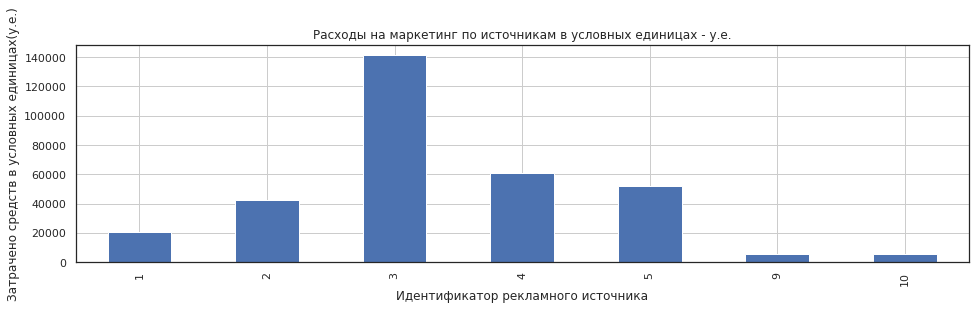

In [35]:
print('Общая сумма расходов на маркетинг:', data_costs['costs'].sum(), 'у.е.')
data_costs_group = data_costs.groupby(['source_id'])['costs'].sum()
print(data_costs_group)
data_costs_group.plot(grid=True, kind='bar', figsize=(16, 4), legend=False)
plt.title('Расходы на маркетинг по источникам в условных единицах - у.е.')
plt.xlabel('Идентификатор рекламного источника')
plt.ylabel('Затрачено средств в условных единицах(у.е.)')
plt.show()

Наиболее затратный - источник № 3, далее идут - источник № 4 и источник № 5. Наименее затратные - источник № 9 и источник № 10. Остальные находятся в среднем диапазоне. Валюта измеряется в условных единицах (у.е.).

In [36]:
data_costs_group = data_costs.groupby(['source_id', 'data_costs_month'])['costs'].sum()
data_costs.pivot_table(index=['data_costs_year', 'data_costs_month'], columns='source_id', values='costs', aggfunc='sum')

source_id                              1        2         3        4   \
data_costs_year data_costs_month                                        
2017            6                 1125.61  2427.38   7731.65  3514.80   
                7                 1072.88  2333.11   7674.37  3529.73   
                8                  951.81  1811.05   6143.54  3217.36   
                9                 1502.01  2985.66   9963.55  5192.26   
                10                2315.75  4845.00  15737.24  6420.84   
                11                2445.16  5247.68  17025.34  5388.82   
                12                2341.20  4897.80  16219.52  7680.47   
2018            1                 2186.18  4157.74  14808.78  5832.79   
                2                 2204.48  4474.34  14228.56  5711.96   
                3                 1893.09  3943.14  13080.85  5961.87   
                4                 1327.49  2993.70   9296.81  4408.49   
                5                 1467.61  2689.44   9411.42  4214.21   

source_id                              5       9       10  
data_costs_year data_costs_month                           
2017            6                 2616.12  285.22  314.22  
                7                 2998.14  302.54  329.82  
                8                 2185.28  248.93  232.57  
                9                 3849.14  415.62  460.67  
                10                5767.40  609.41  627.24  
                11                6325.34  683.18  792.36  
                12                5872.52  657.98  645.86  
2018            1                 5371.52  547.16  614.35  
                2                 5071.31  551.50  480.88  
                3                 4529.62  480.29  526.41  
                4                 3501.15  373.49  388.25  
                5                 3669.56  362.17  409.86

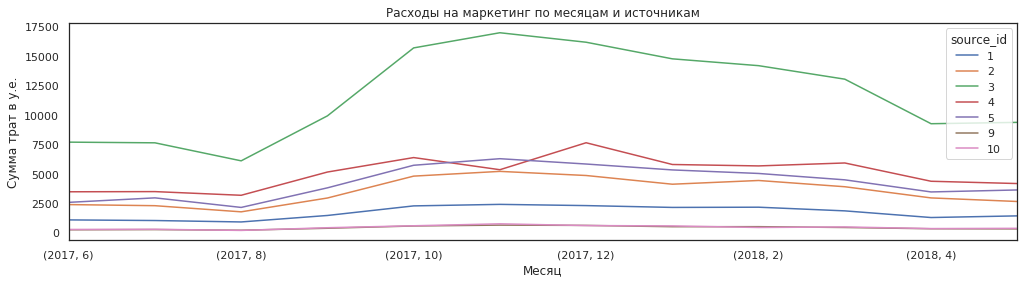

In [37]:
data_costs.pivot_table(index=['data_costs_year', 'data_costs_month'], columns='source_id', values='costs', aggfunc='sum').plot(title = 'Расходы на маркетинг по месяцам и источникам', figsize = (17,4))
plt.xlabel('Месяц')
plt.ylabel('Сумма трат в у.е.')
plt.show()

Заметный рост трат на маркетинг приходится с августа по ноябрь. 

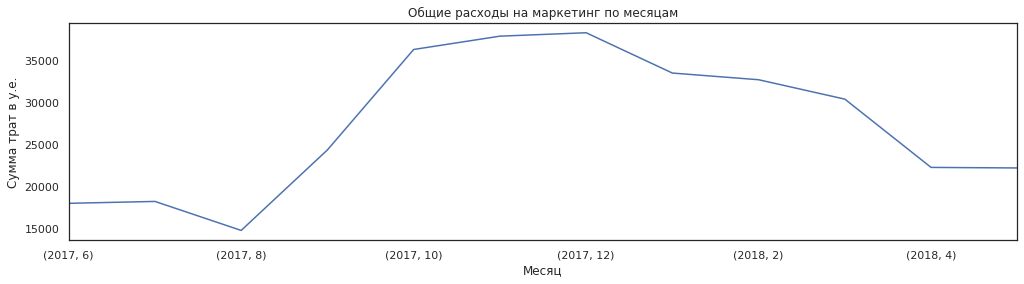

In [38]:
data_costs_groupp = data_costs.groupby(['data_costs_year', 'data_costs_month'])['costs'].sum()
data_costs_groupp.plot(title = 'Общие расходы на маркетинг по месяцам', figsize = (17,4))
plt.xlabel('Месяц')
plt.ylabel('Сумма трат в у.е.')
plt.show()

Как и в расходах на маркетинг по каждому источнику, так и в общих расходах на маркетинг, заметный рост трат на маркетинг приходится с августа по ноябрь. Динамика изменения суммарных расходов с динамикой изменения расходов по каждому из источников - совпадают.

**2.3.2.** Рассчитаем CAC:

CAC (от англ. customer acquisition cost) — стоимость привлечения клиента. Сумма денег, во сколько обходится новый клиент компании.

In [39]:
# Посчитаем CAC каждой когорты. Сначала найдём суммарные расходы за каждый месяц, а затем поделим их на количество покупателей в каждой когорте:
monthly_costs = data_costs_copy.groupby('month').sum()
# Добавим данные о расходах в отчёт и посчитаем CAC:
report_new = pd.merge(report, monthly_costs, left_on='first_order_month', right_on='month')
report_new['cac'] = report_new['costs'] / report_new['n_buyers']
report_new.head() 

,first_order_month,n_buyers,order_month,revenue,gp,age,ltv,source_id,costs,cac
0,2017-06-01,2023,2017-06-01,9557.49,9557.49,0,4.724414,1020,18015.0,8.905091
1,2017-06-01,2023,2017-07-01,981.82,981.82,1,0.485329,1020,18015.0,8.905091
2,2017-06-01,2023,2017-08-01,885.34,885.34,2,0.437637,1020,18015.0,8.905091
3,2017-06-01,2023,2017-09-01,1931.30,1931.30,3,0.954671,1020,18015.0,8.905091
4,2017-06-01,2023,2017-10-01,2068.58,2068.58,4,1.022531,1020,18015.0,8.905091


**2.3.3.** Рассчитем ROMI по когортам в разрезе источников. Сравним окупаемость за одинаковые периоды жизни когорт:

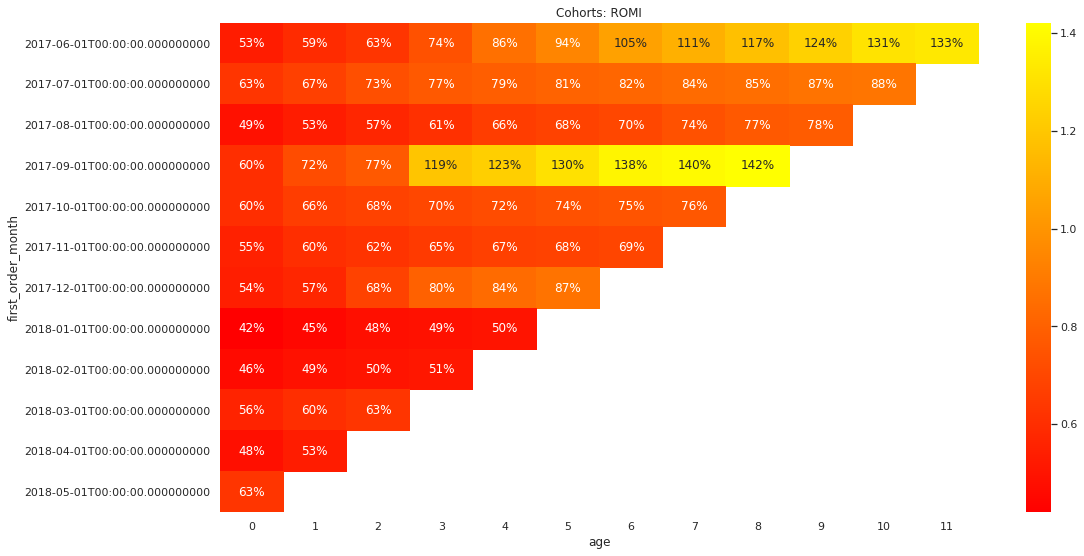

In [40]:
report_new['romi'] = report_new['ltv'] / report_new['cac']
output_romi = report_new.pivot_table(
        index='first_order_month', 
        columns='age', 
        values='romi', 
        aggfunc='mean').cumsum(axis=1).round(2)

sns.set(style='white')
plt.figure(figsize=(17, 9))
plt.title('Cohorts: ROMI')
sns.heatmap(output_romi, annot=True, fmt='.0%',cmap="autumn");

In [41]:
output_romi.mean(axis=0)

age
0     0.540833
1     0.582727
2     0.629000
3     0.717778
4     0.783750
5     0.860000
6     0.898333
7     0.970000
8     1.052500
9     0.963333
10    1.095000
11    1.330000
dtype: float64

- 50% окупаемости происходит в первый месяц.
- окупились 1 и 4 кагорты
- кагорты 2 и 7 наиболее близки к окупаемости

## Выводы и рекомендации
<a id='cell6'></a>

**3.1.** Определите источники трафика, на которые маркетологам стоит делать упор. Объясните свой выбор: на какие метрики вы ориентируетесь и почему:

In [42]:
data_costs_group = data_costs.groupby(['source_id'])['costs'].sum()
print(data_costs_group)

source_id
1      20833.27
2      42806.04
3     141321.63
4      61073.60
5      51757.10
9       5517.49
10      5822.49
Name: costs, dtype: float64


In [43]:
table1 = data_orders.groupby('uid')['revenue'].sum().reset_index()
table2 = data_visits_copy
table2 = table2.merge(table1, on ='uid')
table3 = table2.groupby('uid')['start_ts'].min().reset_index()
table4 = table2.merge(table3, on = ['uid','start_ts'], how = 'inner')
print('Общая выручка составляет:', table4['revenue'].sum())

Общая выручка составляет: 252057.2


In [44]:
revenue_group = table4.groupby('source_id')['revenue'].sum().reset_index()
costs_group = data_costs.groupby('source_id')['costs'].sum().reset_index()
source_group = table4.groupby('source_id')['uid'].nunique().reset_index()
costs_group = costs_group.merge(source_group,on = 'source_id')
costs_group['cost_per_user'] = costs_group['costs'] / costs_group['uid']
costs_group = costs_group.merge(revenue_group,on = 'source_id')
costs_group
costs_group['gp'] = costs_group['revenue'] * margin_rate
costs_group['ltv'] = costs_group['gp'] / costs_group['uid']
costs_group['roi'] = costs_group['ltv'] / costs_group['cost_per_user'] * 100
costs_group

,source_id,costs,uid,cost_per_user,revenue,gp,ltv,roi
0,1,20833.27,2899,7.186364,31090.55,31090.55,10.724577,149.235094
1,2,42806.04,3506,12.209367,46923.61,46923.61,13.383802,109.619133
2,3,141321.63,10473,13.493901,54511.24,54511.24,5.204931,38.572468
3,4,61073.60,10296,5.931779,56696.83,56696.83,5.506685,92.833614
4,5,51757.10,6931,7.467479,52624.02,52624.02,7.592558,101.674978
5,9,5517.49,1088,5.071222,5759.40,5759.40,5.293566,104.384421
6,10,5822.49,1329,4.381106,4450.33,4450.33,3.348631,76.433450


ROI (возврат на инвестиции):
Маркетологам стоит сделать упор на источник трафика №1, тк он самый прибыльный. Также стоит обратить внимание и на источники №2, №5 и №9. 
Самый убыточный источник - № 3, в него вложено самое большое количество средств.
Также не стоит рассматривать источник № 10. 

**3.2.** Выводы, после подсчёта метрик каждого вида: маркетинговых, продуктовых и метрик электронной коммерции:

Продуктовые метрики:

- Пользователи крайне редко возвращаются на сайт
- В среднем, пользователи заходят на сайт 987 раз в день
- Продолжительность средней пользовательской сессии состовляет от 1 до 15 минут

Метрики электронной коммерции:

- Для совершения первой покупки, клиентам требуется не более 15 минут
- Средний чек составляет около 5 у.е.
- В первый месяц клиенты приносят основной доход

Маркетинговые метрики:

- Общая сумма расходов на маркетинг: 329131.62 у.е.
- 50% окупаемости происходит в первый месяц

Выводы по целям проекта:

помочь маркетологам снизить расходы — отказаться от невыгодных источников трафика и перераспределить бюджет;

- Самый убыточный источник - № 3. От него необходимо отказаться.
- Также не стоит рассматривать источник № 10. Стоит задуматься об отказе от данного источника.

определить источники трафика, на которые маркетологам стоит делать упор;

- Маркетологам стоит сделать упор на источник трафика №1, так как он самый прибыльный. 
- Также стоит обратить внимание и на источники №2, №5 и №9.

определить самые перспективные для компании когорты клиентов;

- Самые перспективные кагорты: кагорта № 1(июнь 2017) и кагорта № 4(сентябрь 2017)
- Также очень перспективна кагорта № 7(декабрь 2017)
